### T5 : Proyecto Visión por Computador : " Identificación de cáncer, hiperplasia y pólipos en muestras histológicas de endometrios utilizando una arquitectura VGG16"

Curso: Inteligencia Artificial

Alumna: Francisca Yepsen

Fecha : Noviembre 27 2025

_Comentario de formato : Aquellos bloques que tuvieron inspiración de código externo, tiene comentado el número de la fuente que se corrresponde con el listado de referencias al final del notebook._

#### Paso preliminar 1: Instalación e importación de librerías

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Comando instalación de librerías por uso de ambiente
%pip install -q tensorflow keras scikit-learn matplotlib seaborn pillow plotly

In [50]:
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random
import pandas as pd
import numpy as np
from tensorflow.keras.applications import VGG16
import os
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau,
    EarlyStopping, CSVLogger
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score)
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
import plotly.figure_factory as ff

#### Paso preliminar 2: Configuración de GPU

In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
# REF : https://colab.research.google.com/notebooks/gpu.ipynb
# La ejecución de quiere hacer con la GPU pero no se reconoce automáticamente
#config para uso de GPU en google colab
if gpus:
    try:
        # Configurar el crecimiento de memoria en la primera GPU detectada
        tf.config.experimental.set_memory_growth(gpus[0], True)

        # Opcional: Limitar la GPU visible si hay varias
        tf.config.set_visible_devices(gpus[0], 'GPU')

        print("GPU listaa.")

    except RuntimeError as e:
        # Los errores de configuración deben atraparse inmediatamente
        print(f"No se está utilizando hubo un error: {e}")

GPU listaa.


In [5]:
#ref :
# definir funciones previamente para mostrar las imégenes luego de haber entrenado el modelo

def plot_image(image, prediction, label):

    label_names = ['EA', 'NE', 'EP', 'EH']

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(array_to_img(image * 255), interpolation='nearest')

    #like one-hot
    predicted_label = np.argmax(prediction, axis = -1)

    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("Prediction: {} {:2.0f}% \n Actual: ({})".format(label_names[predicted_label], 100 * prediction[0], label_names[label]), color=color)


#### Comentario sobre el modelo a evaluar :
Se realiza un análisis sólo con uno de los modelos preentrenados de CV, en este caso VGG16. Una red neuronal profunda. Como no se construye desde cero, se hace un "transfer learning".

#### a) Carga y distribución de las imágenes

- Metadata :
    - Nombre de archivo root : histopathological image dataset for ET
    - Tipo de archivo original : ZIP
    - Tipo de archivo subdirectorios : JPEG
    - Magnitud : (197.72 MB)
    - WEB : figshare
    - Funding : National Basic Research Program of China

La estructura del dataset contiene 4 clases principales, algunas con subdirectorios:

| Clase | Descripción | Subdirectorio 1 | Subdirectorio 2 | Subdirectorio 3 | Cantidad Sub 1 | Cantidad Sub 2 | Cantidad Sub 3 | Total |
|-------|-------------|-----------------|-----------------|-----------------|----------------|----------------|----------------|-------|
| **EA** | Endometrio con adenocarcinoma | - | - | - | - | - | - | **535** |
| **EH** | Endometrio con hiperplasia | Complex | Simple | - | 282 | 516 | - | **798** |
| **EP** | Endometrio con pólipos | - | - | - | - | - | - | **636** |
| **NE** | Endometrio Normal | Follicular | Luteal | Menstrual | 712 | 600 | 21 | **1333** |
| | | | | | | | **TOTAL** | **3302** |

- Considerando que se necesita que estén todas las imágenes juntas bajo una misma clase, es que se trabaja con una copia de los datos originales. Y se aplanan los subdirectorios para solo trabajar con las 4 clases principales.

In [7]:
#Esto fue cuando se utilizó en colab, despúes se dejó de usar por alcanzar el límite
DATA_DIR = ('/content/drive/MyDrive/histopathological_image_dataset_for_ET')

In [ ]:
#DATA_DIR = 'histopathological_image_dataset_for_ET'

#### b) Balance de datos

Al realizar el proyecto, hubo un descuido de no revisar el balance de las clases de forma anterior a entrenar el modelo. Por lo que la primera configuración es sin balance. Luego de esa equivocación se realiza con el balance de pesos automáticos. Pero se hace por cada configuración.

**Distribución por categoría Benigno/Maligno:**

| Categoría | Clases que contempla | Cantidad | Porcentaje |
|-----------|---------------------|----------|------------|
| **Benigno** | NE, EH, EP | **2767** | **83.8%** |
| **Maligno** | EA | **535** | **16.2%** |
| | | **TOTAL: 3302** | **100%** |

Nota : Si bien los casos de malignos son pocos, y por ende la cantidad de muestras de cáncer son solo del 16%. Es importante notar que las clasificaciones de aquellas patologías que están dentro de las muestras beningnas de todas formas son importantes de clasificar y detectar. Considerando que pueden cohexistir o derivar a casos malignos.

### I) Modelo VGG16 primera configuración

#### c) Aplanar los subirectorios a solo clases principales

#### Comentario del procedimiento :
- Considerando que las carpetas tienen estructura anidada, no es posible su procesamiento directo. Por ende se utilizan herramientas de Keras para el reconocimiento automático.
- Por otro lado, las imágenes no están originalmente divididas en train-test-val. Entonces una opción es hacer la separación manual, pero por complejidad se realiza con la misma herramienra de Keras que hace la división automática de Train y Val sets.
- ImageDataGenerator permite hacer data augmentation. Por ende se realiza este proceso de forma separada para cada configuración de prueba del modelo VGG16.
- **Se utiliza como técnica de aumentación : "Flipping, cropping, rotation and shifting"**

In [28]:
IMG_SIZE = (224,224)
BATCH_SIZE = 64

new_data_1ub = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split = 0.2,
    brightness_range=[0.8, 1.2],
    zoom_range= 0.1
    )

val_datagen_1ub = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_1ub = new_data_1ub.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE, #ajuste de dimensión de las imágenes
    batch_size=BATCH_SIZE, #cantidad de imágenes que se procesan en cada iteración
    class_mode='categorical', #tipo de clasificación
    shuffle=True, #mezcla de imágenes
    subset = 'training' # indica que set se está separando
)
val_generator_1ub = val_datagen_1ub.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset = 'validation', # indica que es el set con el que se va a validar las salidas del modelo
    shuffle=False,

)


print(f"Clases encontradas por keras :D: {train_generator_1ub.class_indices}")
print(f"Muestras Entrenamiento: {train_generator_1ub.samples}")
print(f"Muestras de validación: {val_generator_1ub.samples}")

Found 2643 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Clases encontradas por keras :D: {'EA': 0, 'EH': 1, 'EP': 2, 'NE': 3}
Muestras Entrenamiento: 2643
Muestras de validación: 659


#### b) Instanciar modelo VGG16 pre entrenado

In [40]:
#variante 1 no balanceada
#se utiliza el modelo VGG16 preentrenado en ImageNet como base.
vgg16_var1ub = VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

#### Visualización de las imágenes con data augmentation

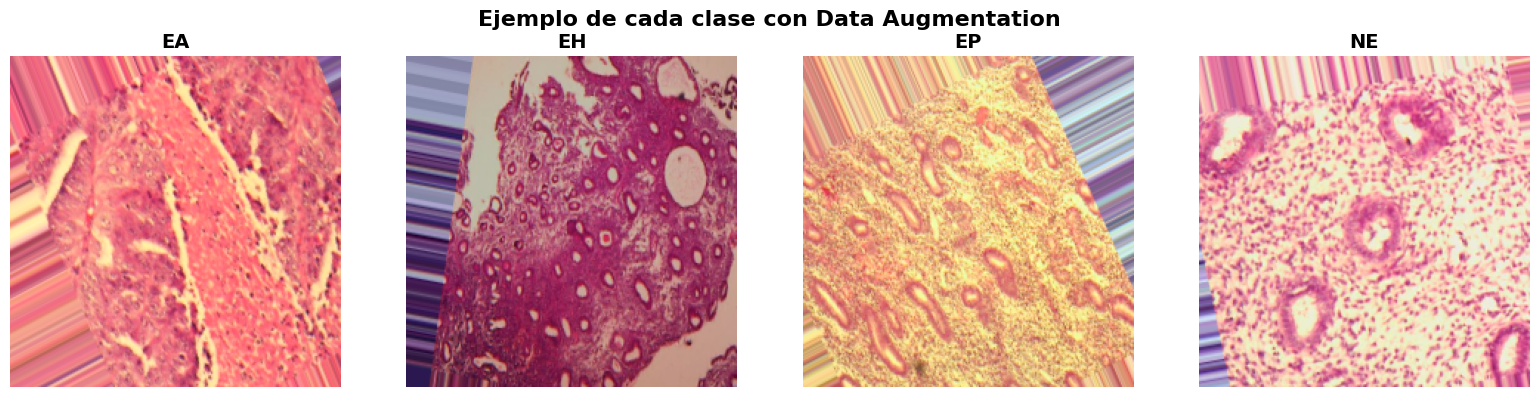

In [41]:
# Visualización de las imagenes con data augmentation aplicada
#Se utilizó copilot para generar este bloque (1), el detalle de la conversación está al final
class_names = list(train_generator_1ub.class_indices.keys())
samples_per_class = {name: None for name in class_names}

#Recorremos para sacar 1 imagen por clase de las muestras aumentadas (train generator)
for i in range(len(train_generator_1ub)):
    x_batch, y_batch = next(train_generator_1ub) #

    for j in range(len(x_batch)):
        class_idx = np.argmax(y_batch[j])
        class_name = class_names[class_idx]

        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = x_batch[j]

    # Si ya tenemos todas, salir
    if all(v is not None for v in samples_per_class.values()):
        break

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (class_name, img) in enumerate(samples_per_class.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Ejemplo de cada clase con Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

train_generator_1ub.reset() # Reiniciar el generador para futuras iteraciones

#### Comentario : Transfer Learning
- Como se utiliza un modelo pre entrenado las capas base no se modifican. Por ello se deben congelar.
- Lo que si se hace es agregar procedimientos al final. Que son particulares a este análisis.


In [42]:
#Congelamos capas base que ya están previamente entrenadas
for layer in vgg16_var1ub.layers:
  layer.trainable = False

#### c) Capas finales nuevas

In [43]:
#referencia código externo (11)
x = vgg16_var1ub.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_1ub = Model(inputs=vgg16_var1ub.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_1ub.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_1ub.layers])}")

Total de capas: 27
Capas congeladas: 19


#### d) Compilar y entrenar modelo

In [44]:
#referencia código externo (11)
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_1ub.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_1ub.summary()
#definición de early stopping : se detiene el entrenamiento si no hay mejora en la métrica por 5 iteraciones seguidas
#referencia código externo (12)
es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [45]:
history_1ub = model_1ub.fit(
          train_generator_1ub,
          epochs=25,
          validation_data=val_generator_1ub,
          callbacks=[es, check_pt],
          verbose=1)

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - acc: 0.4835 - loss: 1.6060
Epoch 1: val_acc improved from -inf to 0.45372, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - acc: 0.4844 - loss: 1.6006 - val_acc: 0.4537 - val_loss: 1.1587
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - acc: 0.5784 - loss: 0.9964
Epoch 2: val_acc did not improve from 0.45372
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5788 - loss: 0.9956 - val_acc: 0.4385 - val_loss: 1.1524
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - acc: 0.6200 - loss: 0.8906
Epoch 3: val_acc did not improve from 0.45372
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6201 - loss: 0.8906 - val_acc: 0.4203 - val_loss: 1.2556
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - acc: 0.6304 - loss: 0.8520
Epoch 4: val_acc did not improve from 0.45372
42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - acc: 0.6302 - loss: 0.8525 - val_acc: 0.2534 - val_loss: 1.3103
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - acc: 0.6619 - loss: 0.8236
Epoch 5: val_acc improved from 0.45372 to 0.49772, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6613 - loss: 0.8244 - val_acc: 0.4977 - val_loss: 1.1063
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - acc: 0.6366 - loss: 0.8502
Epoch 6: val_acc did not improve from 0.49772
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6367 - loss: 0.8499 - val_acc: 0.4856 - val_loss: 1.0738
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.6777 - loss: 0.7649
Epoch 7: val_acc did not improve from 0.49772
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6775 - loss: 0.7658 - val_acc: 0.3794 - val_loss: 1.2824
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - acc: 0.6596 - loss: 0.8139
Epoch 8: val_acc did not improve from 0.49772
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6595 - loss: 0.8138 - val_acc: 0.4977 - val_loss: 1.0836
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - acc: 0.6725 - loss: 0.7917
Epoch 9: val_acc improved from 0.49772 to 0.50683, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6723 - loss: 0.7917 - val_acc: 0.5068 - val_loss: 1.1644
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - acc: 0.6603 - loss: 0.7989
Epoch 10: val_acc did not improve from 0.50683
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6604 - loss: 0.7987 - val_acc: 0.4492 - val_loss: 1.3069
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - acc: 0.6686 - loss: 0.7658
Epoch 11: val_acc improved from 0.50683 to 0.50835, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6686 - loss: 0.7661 - val_acc: 0.5083 - val_loss: 1.2873
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - acc: 0.6670 - loss: 0.7959
Epoch 12: val_acc improved from 0.50835 to 0.51593, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - acc: 0.6670 - loss: 0.7955 - val_acc: 0.5159 - val_loss: 1.1912
Epoch 13/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - acc: 0.6827 - loss: 0.7428
Epoch 13: val_acc did not improve from 0.51593
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6827 - loss: 0.7428 - val_acc: 0.5068 - val_loss: 1.2291
Epoch 14/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - acc: 0.6810 - loss: 0.7696
Epoch 14: val_acc did not improve from 0.51593
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6812 - loss: 0.7692 - val_acc: 0.4719 - val_loss: 1.3104
Epoch 15/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - acc: 0.6934 - loss: 0.7364
Epoch 15: val_acc did not improve from 0.51593
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6931 - loss: 0.7366 - val_acc: 0.4431 - val_loss: 1.2825
Epoch 16/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - acc: 0.6948 - loss: 0.7385
Epoch 16: val_acc did not improve from 0.51593
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.6945 - loss: 0.7

#### e1) Gráfica EPOCHS VS ACCURACY

In [46]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_1ub.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_1ub.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    template='plotly_white'
)

fig.show()

#### e2) Gráfica EPOCHS VS LOOS

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_1ub.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_1ub.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

#### f) Métricas de rendimiento

In [48]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_1ub.predict(val_generator_1ub, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_1ub.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.64      0.30      0.41       107
          NE       0.47      0.37      0.41       159
          EP       0.32      0.12      0.17       127
          EH       0.54      0.88      0.67       266

    accuracy                           0.52       659
   macro avg       0.49      0.42      0.42       659
weighted avg       0.50      0.52      0.47       659



In [51]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()


#### Análisis resultados:
- La clase mejor predicha es la de endometrio con hiperplasia y la peor es endométrios con polipos.
- Los casos de adenocarcinoma se clasifican como endometrios normales, lo que es ** altamente peligroso**.
- La mayoría de las clasificaciones son confundidas con endométrios con hiperplasia.
- El **accuracy general es de 52%** que no es un mal inicio para clases no balanceadas y aumentaciones bruscas.
- En los casos de adenocarcinoma hay un trade of importante de precisión y recall. Eso hace que su F1 sea bastante bajo. Prácticamente inutilizable.
- El peor rendimiento estuvo en la identificación de endométrios con polipos. Su F1 es extremadamente bajo. Eso significa que la identificación de casos positivos y de correctos positivos es escasa.
- Respecto al accuracy avg, tratando a todas las clases por igual está en 42% y el macro que considera el peso por cada una de las clases (análisis del desbalance) está en **%47**. Un resultado malo, y peligroso para este tipo de datos.



#### Consideraciones :
- Hay problemas en la clasificación de clases que son benignas.
- Falta balancear las clases, considerando que el maligno es tiene menos imágenes, pero además entre clases beningnas hay desbalance, no a la magnitud respecto a los de adenocarcinoma, pero sí el mayor número está en muestras de endometrios normales.
- Los valores que se pusieron en la aumentación son bastante agresivos, considerando que el brillo está en valores altos, la rotación está casi a la mitad. Por lo tanto considerando que son imágenes sensibles y que no hay un entrenamiento desde la base, hay que bajar los valores.
- Puede ser que el learning rate esté demasiado alto, y que la complejidad de las imágenes, considerando que las beningnas se parecen mucho pueden de necesitar un valor más pequeño.


**Por lo tanto la primera variante de este modelo (no balanceada) es ineficaz y tienen un rendimiento malo para el área y la teoría en general**

### I_b) Modelo variación 1 balanceado

In [63]:
#Para no tener problema con los generadores
train_generator_1ub.reset()
val_generator_1ub.reset()
train_generator_1ub.on_epoch_end()

In [64]:
#variante 1 balanceada
#se utiliza el modelo VGG16 preentrenado en ImageNet como base.
vgg16_var1b = VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

In [65]:
#Congelamos capas base que ya están previamente entrenadas
for layer in vgg16_var1b.layers:
  layer.trainable = False

In [66]:
#referencia código externo (11)
x = vgg16_var1b.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_1ub = Model(inputs=vgg16_var1b.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_1ub.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_1ub.layers])}")

Total de capas: 27
Capas congeladas: 19


In [67]:
#referencia código externo (11)
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_1ub.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_1ub.summary()
#definición de early stopping : se detiene el entrenamiento si no hay mejora en la métrica por 5 iteraciones seguidas
#referencia código externo (12)
es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [68]:
class_weights_v1 = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_1ub.classes),
    y=train_generator_1ub.classes
)
class_weight_dict_1 = {i: weight for i, weight in enumerate(class_weights_v1)} #keras necesita saber que peso corresponde a cada clase!

In [69]:
history_1b= model_1ub.fit(
          train_generator_1ub,
          epochs=25,
          validation_data=val_generator_1ub,
          class_weight = class_weight_dict_1,
          callbacks=[es, check_pt],
          verbose=1)

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - acc: 0.4392 - loss: 1.5750
Epoch 1: val_acc improved from -inf to 0.42944, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.4404 - loss: 1.5697 - val_acc: 0.4294 - val_loss: 1.4069
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - acc: 0.5618 - loss: 0.9570
Epoch 2: val_acc did not improve from 0.42944
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5620 - loss: 0.9567 - val_acc: 0.2747 - val_loss: 1.5048
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - acc: 0.5874 - loss: 0.8858
Epoch 3: val_acc improved from 0.42944 to 0.48255, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5874 - loss: 0.8860 - val_acc: 0.4825 - val_loss: 1.0604
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - acc: 0.6051 - loss: 0.8702
Epoch 4: val_acc improved from 0.48255 to 0.49469, saving model to vgg16_finetune.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6050 - loss: 0.8699 - val_acc: 0.4947 - val_loss: 1.0475
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - acc: 0.6343 - loss: 0.8283
Epoch 5: val_acc did not improve from 0.49469
42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.6340 - loss: 0.8286 - val_acc: 0.4856 - val_loss: 1.0601
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.6339 - loss: 0.7968
Epoch 6: val_acc did not improve from 0.49469
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6336 - loss: 0.7975 - val_acc: 0.4765 - val_loss: 1.0864
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - acc: 0.6156 - loss: 0.8081
Epoch 7: val_acc did not improve from 0.49469
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6160 - loss: 0.8081 - val_acc: 0.4507 - val_loss: 1.1508
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - acc: 0.6361 - loss: 0.7666
Epoch 8: val_acc did not improve from 0.49469
42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.6364 - loss: 0.7664 - va

#### e1) Gráfica EPOCHS VS ACCURACY

In [70]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_1b.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_1b.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    template='plotly_white'
)

fig.show()

#### e2) Gráfica EPOCHS VS LOSS

In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_1b.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_1b.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

#### f) Métricas de rendimiento

In [72]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_1ub.predict(val_generator_1ub, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_1ub.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.51      0.53      0.52       107
          NE       0.45      0.40      0.43       159
          EP       0.36      0.65      0.46       127
          EH       0.69      0.46      0.55       266

    accuracy                           0.49       659
   macro avg       0.50      0.51      0.49       659
weighted avg       0.54      0.49      0.50       659



In [73]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()

###Análisis de resultados
- El rendimiento es considerablemente mejor. Las curvas de loss y accuracy entre train y val no están tan divergentes como en el modelo previo. Lo que es un buen indicador.
- Por otro lado el **accuracy es de 49%**. Es más bajo que en la configuración previa, sin embargo en las métricas de F1 por clase hay una mejora notable.
- El con mejor F1 sigue siendo la muestra con hiperplasia pero está muy cerca con la de adenocarcinoma. Lo que significa que esta última mejoró. Aún un valor de ~ 50% es bajo y peligroso.
- El F1 de la muestra con polipos subió desde 0.17 a 0.46. El desbalance afectaba de gran medida.
- Hay 8 menos predicciones de supuestos endometrios normales que tenían adenocarcinoma.
- Las muestras de hiperplasia y polipos tienen aún valores de clasificación mezclada entre sí, considerable.



#### Consideraciones:
- Si bien las clases están balanceadas ahora y eso mejoró el rendimiento general, aún los valores de aumento se mantuvieron y son bastante agresivos.
- El entrenamiento se detuvo en el EPOCH 9. Esto debido a que durante 5 iteraciones, las métricas de accuracy del set de validación no subían. Por lo que puede ser que con una espera mayor lo resultados hubieran cambiado.

### II Modelo variación 2 (balanceado)

In [76]:
train_datagen_2= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range= [0.5,0.8],
    zoom_range=[0.1,0.5],
    validation_split=0.2
)

# VALIDATION: SOLO rescale (sin augmentation)
val_datagen_2 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_2 = train_datagen_2.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator_2 = val_datagen_2.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Clases encontradas por keras :D: {train_generator_2.class_indices}")
print(f"Muestras Entrenamiento: {train_generator_2.samples}")
print(f"Muestras de validación: {val_generator_2.samples}")


Found 2643 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Clases encontradas por keras :D: {'EA': 0, 'EH': 1, 'EP': 2, 'NE': 3}
Muestras Entrenamiento: 2643
Muestras de validación: 659


In [77]:
vgg16_2 = VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

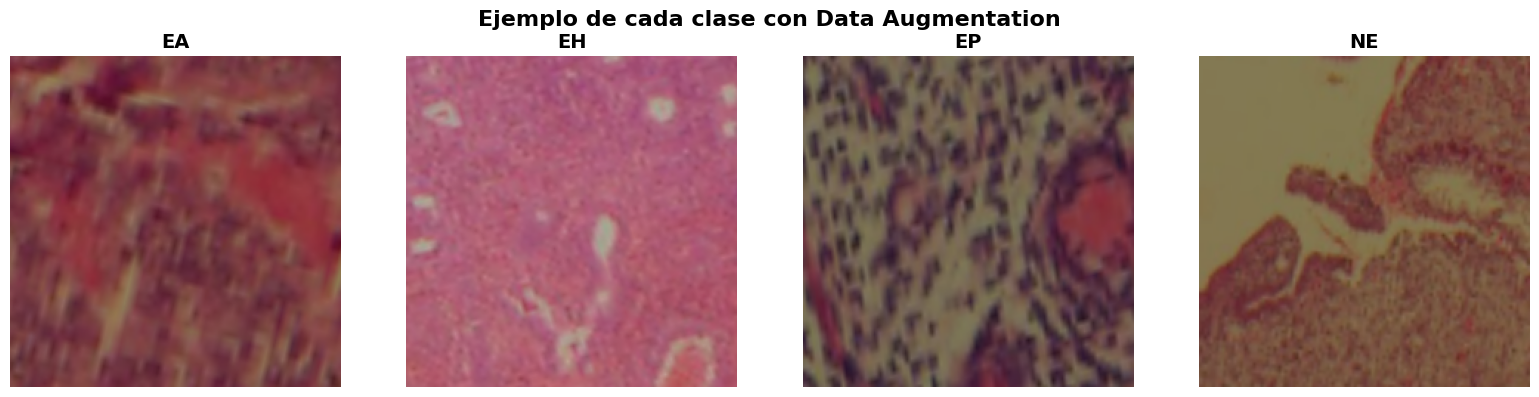

In [78]:
# Visualización de las imagenes con data augmentation aplicada
#Se utilizó copilot para generar este bloque (1), el detalle de la conversación está al final
class_names = list(train_generator_2.class_indices.keys())
samples_per_class = {name: None for name in class_names}

#Recorremos para sacar 1 imagen por clase de las muestras aumentadas (train generator)
for i in range(len(train_generator_2)):
    x_batch, y_batch = next(train_generator_2) #

    for j in range(len(x_batch)):
        class_idx = np.argmax(y_batch[j])
        class_name = class_names[class_idx]

        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = x_batch[j]

    # Si ya tenemos todas, salir
    if all(v is not None for v in samples_per_class.values()):
        break

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (class_name, img) in enumerate(samples_per_class.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Ejemplo de cada clase con Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

train_generator_2.reset() # Reiniciar el generador para futuras iteraciones

In [79]:
for layer in vgg16_2.layers:
  layer.trainable = False

In [80]:
#referencia código externo (11)
x = vgg16_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_2 = Model(inputs=vgg16_2.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_2.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_2.layers])}")

Total de capas: 27
Capas congeladas: 19


In [81]:
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_2.summary()
#definición de early stopping : se detiene el entrenamiento si no hay mejora en la métrica por 5 iteraciones seguidas
#referencia código externo (12)
es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune2.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [82]:
class_weights_2 = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_2.classes),
    y=train_generator_2.classes
)
class_weight_dict_2 = {i: weight for i, weight in enumerate(class_weights_2)} #keras necesita saber que peso corresponde a cada clase!

In [84]:
history_2 = model_2.fit(
          train_generator_2,
          epochs=25,
          validation_data=val_generator_2,
          callbacks=[es, check_pt],
          class_weight = class_weight_dict_2,
          verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - acc: 0.3166 - loss: 2.0525
Epoch 1: val_acc improved from -inf to 0.39454, saving model to vgg16_finetune2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - acc: 0.3173 - loss: 2.0454 - val_acc: 0.3945 - val_loss: 1.7359
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - acc: 0.3681 - loss: 1.4665
Epoch 2: val_acc improved from 0.39454 to 0.40516, saving model to vgg16_finetune2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 996ms/step - acc: 0.3685 - loss: 1.4653 - val_acc: 0.4052 - val_loss: 1.2798
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - acc: 0.4241 - loss: 1.2944
Epoch 3: val_acc improved from 0.40516 to 0.41275, saving model to vgg16_finetune2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 983ms/step - acc: 0.4238 - loss: 1.2948 - val_acc: 0.4127 - val_loss: 1.4053
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - acc: 0.4299 - loss: 1.3027
Epoch 4: val_acc did not improve from 0.41275
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - acc: 0.4299 - loss: 1.3023 - val_acc: 0.2033 - val_loss: 2.1911
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - acc: 0.4051 - loss: 1.3120
Epoch 5: val_acc did not improve from 0.41275
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 977ms/step - acc: 0.4056 - loss: 1.3115 - val_acc: 0.3263 - val_loss: 1.3676
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - acc: 0.4160 - loss: 1.2563
Epoch 6: val_acc did not improve from 0.41275
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 981ms/step - acc: 0.4161 - loss: 1.2558 - val_acc: 0.2564 - val_loss: 1.8917
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - acc: 0.4562 - loss: 1.2437
Epoch 7: val_acc improved from 0.41275 to 0.43854, saving model to vgg16_finetune2.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 983ms/step - acc: 0.4556 - loss: 1.2437 - val_acc: 0.4385 - val_loss: 1.2617
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - acc: 0.4526 - loss: 1.2064
Epoch 8: val_acc did not improve from 0.43854
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - acc: 0.4524 - loss: 1.2064 - val_acc: 0.3096 - val_loss: 1.5298
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - acc: 0.4633 - loss: 1.1838
Epoch 9: val_acc did not improve from 0.43854
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 969ms/step - acc: 0.4634 - loss: 1.1839 - val_acc: 0.2398 - val_loss: 1.9172
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - acc: 0.4264 - loss: 1.2237
Epoch 10: val_acc did not improve from 0.43854
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 985ms/step - acc: 0.4269 - loss: 1.2232 - val_acc: 0.2519 - val_loss: 2.0537
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - acc: 0.4548 - loss: 1.1835
Epoch 11: val_acc did not improve from 0.43854
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - acc: 0.4548 - l

### Gráfica EPOCHS VS ACCURACY

In [85]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_2.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_2.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    template='plotly_white'
)

fig.show()

#### Gráfico EPOCHS VS LOSS

In [86]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_2.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_2.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

#### Métricas de evaluación

In [88]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_2.predict(val_generator_2, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_2.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.34      0.61      0.44       107
          NE       0.22      0.09      0.13       159
          EP       0.31      0.31      0.31       127
          EH       0.61      0.64      0.63       266

    accuracy                           0.44       659
   macro avg       0.37      0.41      0.38       659
weighted avg       0.42      0.44      0.42       659



In [89]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()

#### Análisis resultados:
- Bajó el número de Hiperplásias calificadas como pólipos.
- Bajó los endometrios con cáncer calificados como normales, lo cual es bueno. Pero subió el de endometrios normales predichos con adenocarcinoma. No es un resultado deseable pero es mejor que el diagnóstico inverso.
- Las muestras con hiperplasia siguen siendo las que rinden mejor.
- El**accuracy está en %42**, el más bajo hasta ahora
- El F1 de los endometrios normales bajó muchísimo. El de adenocarcinoma está más bajo que en anterior pero más alto que en la primera configuración.


#### Comentarios:
- El entrenamiento se detuvo al epoch 12.
- El accuracy y el loss están más inestables. Varían demasiado. Aunque hay momentos en que convergen los valores de val con train.
- Peor desempeño que la configuración anterior.
- El aumento disminuyó en valores muy bruscamente

### III Tercera variación (balanceada)

In [150]:
train_datagen_3= ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    validation_split=0.2
)

# VALIDATION: SOLO rescale (sin augmentation)
val_datagen_3 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_3 = train_datagen_3.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator_3 = val_datagen_3.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Clases encontradas por keras :D: {train_generator_3.class_indices}")
print(f"Muestras Entrenamiento: {train_generator_3.samples}")
print(f"Muestras de validación: {val_generator_3.samples}")


Found 2643 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Clases encontradas por keras :D: {'EA': 0, 'EH': 1, 'EP': 2, 'NE': 3}
Muestras Entrenamiento: 2643
Muestras de validación: 659


In [151]:
vgg16_3 = VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

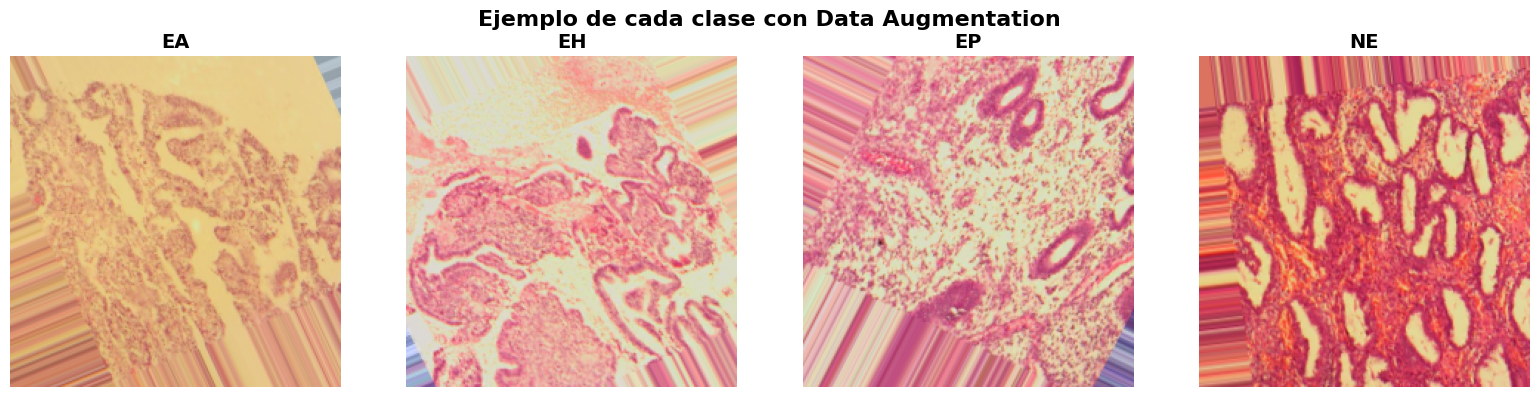

In [152]:
# Visualización de las imagenes con data augmentation aplicada
#Se utilizó copilot para generar este bloque (1), el detalle de la conversación está al final
class_names = list(train_generator_3.class_indices.keys())
samples_per_class = {name: None for name in class_names}

#Recorremos para sacar 1 imagen por clase de las muestras aumentadas (train generator)
for i in range(len(train_generator_3)):
    x_batch, y_batch = next(train_generator_3) #

    for j in range(len(x_batch)):
        class_idx = np.argmax(y_batch[j])
        class_name = class_names[class_idx]

        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = x_batch[j]

    # Si ya tenemos todas, salir
    if all(v is not None for v in samples_per_class.values()):
        break

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (class_name, img) in enumerate(samples_per_class.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Ejemplo de cada clase con Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

train_generator_3.reset() # Reiniciar el generador para futuras iteraciones

In [153]:
for layer in vgg16_3.layers:
  layer.trainable = False

In [154]:
x = vgg16_3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_3 = Model(inputs=vgg16_3.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_3.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_3.layers])}")

Total de capas: 27
Capas congeladas: 19


In [156]:
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_3.summary()
es = EarlyStopping(monitor='val_acc', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune3.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [157]:
class_weights_3 = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_3.classes),
    y=train_generator_3.classes
)
class_weight_dict_3 = {i: weight for i, weight in enumerate(class_weights_3)} #keras necesita saber que peso corresponde a cada clase!

In [158]:
history_3 = model_3.fit(
          train_generator_3,
          epochs=25,
          validation_data=val_generator_3,
          callbacks=[es, check_pt],
          class_weight = class_weight_dict_3,
          verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - acc: 0.4382 - loss: 1.5689
Epoch 1: val_acc improved from -inf to 0.41730, saving model to vgg16_finetune3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - acc: 0.4395 - loss: 1.5634 - val_acc: 0.4173 - val_loss: 1.4716
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - acc: 0.5890 - loss: 0.9279
Epoch 2: val_acc did not improve from 0.41730
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 930ms/step - acc: 0.5890 - loss: 0.9282 - val_acc: 0.3263 - val_loss: 1.3087
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - acc: 0.5905 - loss: 0.9027
Epoch 3: val_acc did not improve from 0.41730
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 942ms/step - acc: 0.5907 - loss: 0.9025 - val_acc: 0.3581 - val_loss: 1.2101
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - acc: 0.6324 - loss: 0.7994
Epoch 4: val_acc improved from 0.41730 to 0.45979, saving model to vgg16_finetune3.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 939ms/step - acc: 0.6324 - loss: 0.7997 - val_acc: 0.4598 - val_loss: 1.1915
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - acc: 0.6559 - loss: 0.7783
Epoch 5: val_acc did not improve from 0.45979
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 929ms/step - acc: 0.6551 - loss: 0.7794 - val_acc: 0.4431 - val_loss: 1.1299
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - acc: 0.6296 - loss: 0.7943
Epoch 6: val_acc did not improve from 0.45979
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 925ms/step - acc: 0.6293 - loss: 0.7951 - val_acc: 0.3035 - val_loss: 1.4499
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - acc: 0.6422 - loss: 0.7801
Epoch 7: val_acc did not improve from 0.45979
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 942ms/step - acc: 0.6422 - loss: 0.7805 - val_acc: 0.3551 - val_loss: 1.6942
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - acc: 0.6431 - loss: 0.7572
Epoch 8: val_acc did not improve from 0.45979
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - acc: 0.6430 - lo

In [161]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_3.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_3.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    template='plotly_white'
)

fig.show()

In [162]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_3.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_3.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

In [163]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_3.predict(val_generator_3, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_3.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.72      0.12      0.21       107
          NE       0.46      0.31      0.37       159
          EP       0.32      0.68      0.43       127
          EH       0.59      0.58      0.58       266

    accuracy                           0.46       659
   macro avg       0.52      0.42      0.40       659
weighted avg       0.53      0.46      0.44       659



In [164]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()

### Análisis:
- Recall más alto de EA. Mayor detección de cáncer.
- Se predice mucho EA en endometrios sanos.
- Hiperplasia mantiene un buen rendimiento.

### IV Variación modelo (balanceada)

In [116]:
#referencia código valore de aumento (13)
train_datagen_4 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=[-15,15],
    height_shift_range=[-15,15],
    brightness_range=[0.28, 2.8],
    zoom_range= 0.1,
    validation_split=0.2,
    fill_mode = 'constant',
    channel_shift_range = 20
)

# VALIDATION: SOLO rescale (sin augmentation)
val_datagen_4 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_4 = train_datagen_4.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator_4 = val_datagen_4.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Clases encontradas por keras :D: {train_generator_4.class_indices}")
print(f"Muestras Entrenamiento: {train_generator_4.samples}")
print(f"Muestras de validación: {val_generator_4.samples}")


Found 2643 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Clases encontradas por keras :D: {'EA': 0, 'EH': 1, 'EP': 2, 'NE': 3}
Muestras Entrenamiento: 2643
Muestras de validación: 659


In [117]:
#variante 1 no balanceada
#se utiliza el modelo VGG16 preentrenado en ImageNet como base.
vgg16_4 = VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

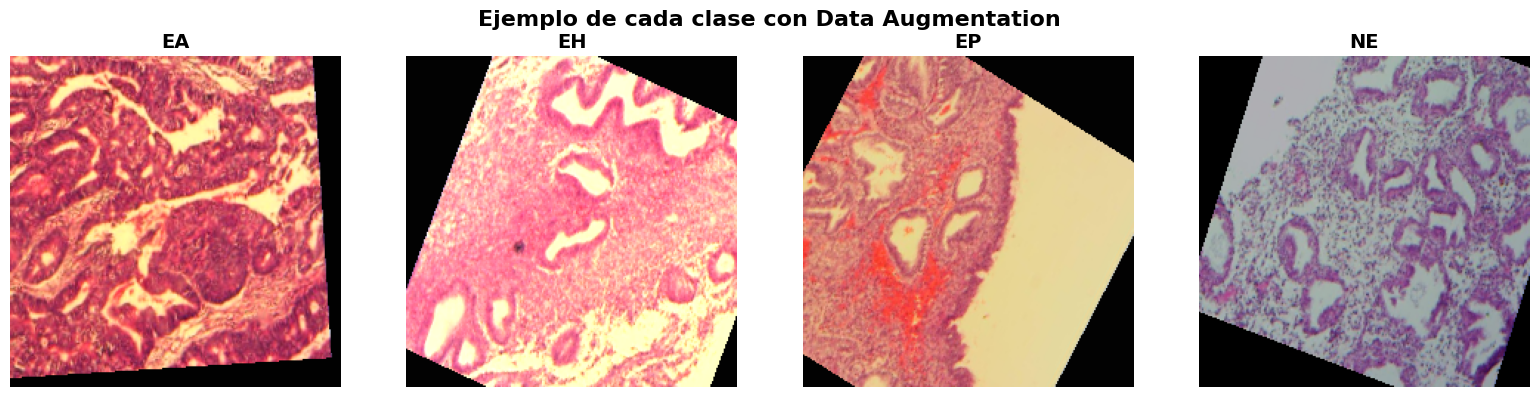

In [118]:
# Visualización de las imagenes con data augmentation aplicada
#Se utilizó copilot para generar este bloque (1), el detalle de la conversación está al final
class_names = list(train_generator_4.class_indices.keys())
samples_per_class = {name: None for name in class_names}

#Recorremos para sacar 1 imagen por clase de las muestras aumentadas (train generator)
for i in range(len(train_generator_4)):
    x_batch, y_batch = next(train_generator_4) #

    for j in range(len(x_batch)):
        class_idx = np.argmax(y_batch[j])
        class_name = class_names[class_idx]

        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = x_batch[j]

    # Si ya tenemos todas, salir
    if all(v is not None for v in samples_per_class.values()):
        break

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (class_name, img) in enumerate(samples_per_class.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Ejemplo de cada clase con Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

train_generator_4.reset() # Reiniciar el generador para futuras iteraciones

In [119]:
#Congelamos capas base que ya están previamente entrenadas
for layer in vgg16_4.layers:
  layer.trainable = False

In [120]:
#referencia código externo (11)
x = vgg16_4.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_4 = Model(inputs=vgg16_4.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_4.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_4.layers])}")

Total de capas: 27
Capas congeladas: 19


In [121]:
#referencia código externo (11)
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_4.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_4.summary()
#definición de early stopping : se detiene el entrenamiento si no hay mejora en la métrica por 5 iteraciones seguidas
#referencia código externo (12)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune4.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [122]:
class_weights_4 = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_4.classes),
    y=train_generator_4.classes
)
class_weight_dict_4 = {i: weight for i, weight in enumerate(class_weights_4)} #keras necesita saber que peso corresponde a cada clase!

In [123]:
history_4 = model_4.fit(
          train_generator_4,
          epochs=25,
          validation_data=val_generator_4,
          callbacks=[es, check_pt],
          class_weight = class_weight_dict_4,
          verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - acc: 0.3684 - loss: 1.9053

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning:

Can save best model only with val_accuracy available.



42/42 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - acc: 0.3694 - loss: 1.8974 - val_acc: 0.2656 - val_loss: 1.2776
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - acc: 0.4793 - loss: 1.1288

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.4792 - loss: 1.1289 - val_acc: 0.4188 - val_loss: 1.0948
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - acc: 0.4841 - loss: 1.0718

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.4844 - loss: 1.0714 - val_acc: 0.4294 - val_loss: 1.0961
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - acc: 0.5316 - loss: 1.0183

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5313 - loss: 1.0182 - val_acc: 0.4203 - val_loss: 1.1906
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - acc: 0.5228 - loss: 0.9846

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5227 - loss: 0.9851 - val_acc: 0.3703 - val_loss: 1.4439
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - acc: 0.5427 - loss: 0.9779

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5425 - loss: 0.9782 - val_acc: 0.4097 - val_loss: 1.2514
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - acc: 0.5711 - loss: 0.9868

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5708 - loss: 0.9865 - val_acc: 0.4219 - val_loss: 1.2674
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - acc: 0.5278 - loss: 0.9713

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5278 - loss: 0.9715 - val_acc: 0.4446 - val_loss: 1.2185
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - acc: 0.5294 - loss: 1.0007

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5297 - loss: 1.0003 - val_acc: 0.4385 - val_loss: 1.2356
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - acc: 0.5442 - loss: 0.9828

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5442 - loss: 0.9827 - val_acc: 0.4674 - val_loss: 1.0912
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - acc: 0.5655 - loss: 0.9251

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5653 - loss: 0.9256 - val_acc: 0.4522 - val_loss: 1.3298
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - acc: 0.5650 - loss: 0.9352

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5650 - loss: 0.9353 - val_acc: 0.4522 - val_loss: 1.1630
Epoch 13/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - acc: 0.5512 - loss: 0.9064

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5514 - loss: 0.9067 - val_acc: 0.3096 - val_loss: 1.7839
Epoch 14/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - acc: 0.5342 - loss: 0.9306

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5345 - loss: 0.9307 - val_acc: 0.5099 - val_loss: 1.6328
Epoch 15/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - acc: 0.5628 - loss: 0.9408

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5627 - loss: 0.9404 - val_acc: 0.3763 - val_loss: 1.4474
Epoch 16/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - acc: 0.5565 - loss: 0.9255

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5567 - loss: 0.9251 - val_acc: 0.4507 - val_loss: 1.3455
Epoch 17/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - acc: 0.5671 - loss: 0.9146

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5669 - loss: 0.9147 - val_acc: 0.4401 - val_loss: 1.4064
Epoch 18/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - acc: 0.5769 - loss: 0.8839

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5768 - loss: 0.8842 - val_acc: 0.4279 - val_loss: 1.5174
Epoch 19/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - acc: 0.5703 - loss: 0.9177

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5702 - loss: 0.9171 - val_acc: 0.3915 - val_loss: 1.4100
Epoch 20/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - acc: 0.5795 - loss: 0.8920

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5795 - loss: 0.8922 - val_acc: 0.4112 - val_loss: 1.3503
Epoch 21/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - acc: 0.5518 - loss: 0.9158

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5520 - loss: 0.9157 - val_acc: 0.4234 - val_loss: 1.5308
Epoch 22/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - acc: 0.5760 - loss: 0.9046

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.5760 - loss: 0.9044 - val_acc: 0.3627 - val_loss: 1.5551
Epoch 23/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - acc: 0.5588 - loss: 0.9149

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5591 - loss: 0.9142 - val_acc: 0.4522 - val_loss: 1.4246
Epoch 24/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - acc: 0.5730 - loss: 0.8898

42/42 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - acc: 0.5728 - loss: 0.8904 - val_acc: 0.3900 - val_loss: 1.5457
Epoch 25/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - acc: 0.6007 - loss: 0.8697

42/42 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc: 0.6005 - loss: 0.8699 - val_acc: 0.4340 - val_loss: 1.6272


In [124]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_4.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_4.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    template='plotly_white'
)

fig.show()

In [125]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_4.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_4.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

In [159]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_4.predict(val_generator_4, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_4.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.53      0.22      0.32       107
          NE       0.39      0.15      0.22       159
          EP       0.39      0.29      0.33       127
          EH       0.44      0.76      0.56       266

    accuracy                           0.43       659
   macro avg       0.44      0.36      0.36       659
weighted avg       0.43      0.43      0.39       659



In [160]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()

#### Análisis:

- Subió bastante la detección de hiperplasia, también los falsos negativos de hiperplasia subieron. Es resultado similar al del primer modelo que tenía aumentos altos y no estaba balanceada
- Ahora los adenocarcinomas se confunden más con hiperplasia. Que al menos es mejor que predecirlos como normales.
- En ninguna ocasión polipos o hiperplasias fueron predichas como adenocarcinomas.
- El accuracy es de 43%
- Los scores de F1 están bastante bajos, el peor es de los endometrios normales. El mejor es del hiperplasia.

#### Comentarios:
- El brillo fue demasiado alto y puede distorcionar mucho. Pero puede que sirva para identificar estructuras más oscuras.
- El shift en esa escala puede traer problemas.
- La variación de colores/brillos parecen haber ayudado a identificar mejor la hiperplasia.
- Hay que tener cuidado con la distorción del shift por la importancia del tamaño de las estructuras. Lo mismo con el zoom.
- Fill mode de contrast útil para que no se distorcione la imagen y las estructuras.

**Hasta ahora podría ser de los peores calificados**


### V) Variación modelo (balanceado)

In [134]:

train_datagen_5 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.6, 1.4],
    zoom_range= 0.15,
    channel_shift_range = 20,
    validation_split=0.2
)

# VALIDATION: SOLO rescale (sin augmentation)
val_datagen_5 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator_5= train_datagen_5.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator_5 = val_datagen_5.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"Clases encontradas por keras :D: {train_generator_5.class_indices}")
print(f"Muestras Entrenamiento: {train_generator_5.samples}")
print(f"Muestras de validación: {val_generator_5.samples}")


Found 2643 images belonging to 4 classes.
Found 659 images belonging to 4 classes.
Clases encontradas por keras :D: {'EA': 0, 'EH': 1, 'EP': 2, 'NE': 3}
Muestras Entrenamiento: 2643
Muestras de validación: 659


In [135]:
vgg16_5= VGG16(weights="imagenet", include_top=False, input_shape =(224,224,3))

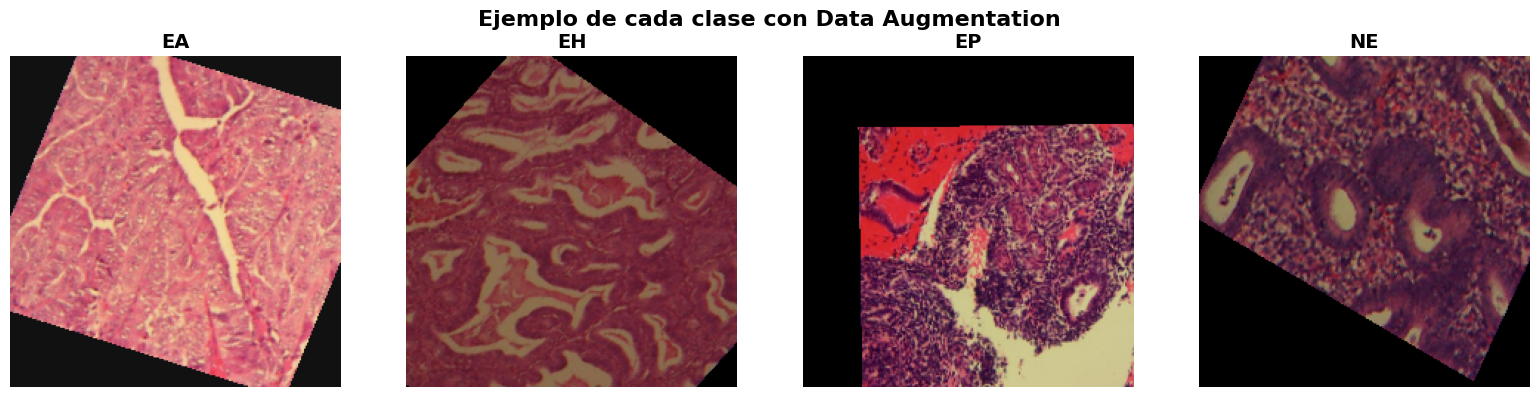

In [136]:

class_names = list(train_generator_5.class_indices.keys())
samples_per_class = {name: None for name in class_names}

#Recorremos para sacar 1 imagen por clase de las muestras aumentadas (train generator)
for i in range(len(train_generator_5)):
    x_batch, y_batch = next(train_generator_5) #

    for j in range(len(x_batch)):
        class_idx = np.argmax(y_batch[j])
        class_name = class_names[class_idx]

        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = x_batch[j]

    # Si ya tenemos todas, salir
    if all(v is not None for v in samples_per_class.values()):
        break

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (class_name, img) in enumerate(samples_per_class.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Ejemplo de cada clase con Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

train_generator_5.reset() # Reiniciar el generador para futuras iteraciones

In [137]:
#Congelamos capas base que ya están previamente entrenadas
for layer in vgg16_5.layers:
  layer.trainable = False

In [138]:
#referencia código externo (11)
x = vgg16_5.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', use_bias = True)(x) #Se parte con numero grande de neuronas
x = BatchNormalization()(x)
x = Dropout(0.5, seed = 42)(x) #aquellas q se apagan para evitar overfitting
x = Dense(256, activation='relu', use_bias = True)(x) #se usa relu por tener una performance estandar buena
x = BatchNormalization()(x)
x = Dropout(0.3, seed = 42)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases: EA, EH, EP, NE

model_5 = Model(inputs=vgg16_5.input, outputs=predictions) #Para definir el modelo final con las nuevas capas

print(f"Total de capas: {len(model_5.layers)}")
print(f"Capas congeladas: {sum([not layer.trainable for layer in model_5.layers])}")

Total de capas: 27
Capas congeladas: 19


In [139]:
#referencia código externo (11)
print("Función de pérdida : Cross Entropy\n")
print("Función de optimización : Adam\n")
print("¡Compilando modelo!......\n")
model_5.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate = 0.005),
              metrics=['acc'])
model_5.summary()
#definición de early stopping : se detiene el entrenamiento si no hay mejora en la métrica por 5 iteraciones seguidas
#referencia código externo (12)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
check_pt = ModelCheckpoint('vgg16_finetune5.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

Función de pérdida : Cross Entropy

Función de optimización : Adam

¡Compilando modelo!......



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,112,772 (57.65 MB)

 Trainable params: 396,548 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [140]:
class_weights_5 = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator_5.classes),
    y=train_generator_5.classes
)
class_weight_dict_5 = {i: weight for i, weight in enumerate(class_weights_5)} #keras necesita saber que peso corresponde a cada clase!

In [141]:
history_5 = model_5.fit(
          train_generator_5,
          epochs=25,
          validation_data=val_generator_5,
          callbacks=[es, check_pt],
          class_weight = class_weight_dict_5,
          verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - acc: 0.3963 - loss: 1.7706

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning:

Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning:

Can save best model only with val_accuracy available.



42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - acc: 0.3978 - loss: 1.7628 - val_acc: 0.2762 - val_loss: 1.7385
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - acc: 0.5427 - loss: 1.0546

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 974ms/step - acc: 0.5428 - loss: 1.0543 - val_acc: 0.2731 - val_loss: 1.5455
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - acc: 0.5499 - loss: 0.9854

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 976ms/step - acc: 0.5503 - loss: 0.9845 - val_acc: 0.3748 - val_loss: 1.1595
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - acc: 0.5722 - loss: 0.9209

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - acc: 0.5721 - loss: 0.9209 - val_acc: 0.4294 - val_loss: 1.1116
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - acc: 0.6018 - loss: 0.8807

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 980ms/step - acc: 0.6017 - loss: 0.8809 - val_acc: 0.3869 - val_loss: 1.2461
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - acc: 0.5999 - loss: 0.8644

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 976ms/step - acc: 0.6001 - loss: 0.8647 - val_acc: 0.4097 - val_loss: 1.2590
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - acc: 0.5974 - loss: 0.8804

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - acc: 0.5974 - loss: 0.8804 - val_acc: 0.3976 - val_loss: 1.1836
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - acc: 0.5639 - loss: 0.8899

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 983ms/step - acc: 0.5645 - loss: 0.8894 - val_acc: 0.4643 - val_loss: 1.1743
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - acc: 0.6163 - loss: 0.8131

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - acc: 0.6162 - loss: 0.8134 - val_acc: 0.3718 - val_loss: 1.3345
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - acc: 0.5900 - loss: 0.8440

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - acc: 0.5903 - loss: 0.8440 - val_acc: 0.3308 - val_loss: 1.3703
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - acc: 0.5995 - loss: 0.8390

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - acc: 0.5997 - loss: 0.8390 - val_acc: 0.4036 - val_loss: 1.2951
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - acc: 0.6014 - loss: 0.8447

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - acc: 0.6017 - loss: 0.8442 - val_acc: 0.5250 - val_loss: 1.1202
Epoch 13/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - acc: 0.6338 - loss: 0.7932

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 979ms/step - acc: 0.6334 - loss: 0.7941 - val_acc: 0.4977 - val_loss: 1.1570
Epoch 14/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - acc: 0.6272 - loss: 0.7853

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 976ms/step - acc: 0.6275 - loss: 0.7855 - val_acc: 0.3581 - val_loss: 1.4675
Epoch 15/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - acc: 0.6168 - loss: 0.8183

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 979ms/step - acc: 0.6170 - loss: 0.8181 - val_acc: 0.3551 - val_loss: 1.5611
Epoch 16/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - acc: 0.6436 - loss: 0.7454

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 973ms/step - acc: 0.6434 - loss: 0.7462 - val_acc: 0.5099 - val_loss: 1.1476
Epoch 17/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - acc: 0.6309 - loss: 0.7950

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 971ms/step - acc: 0.6310 - loss: 0.7948 - val_acc: 0.4795 - val_loss: 1.2057
Epoch 18/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - acc: 0.6286 - loss: 0.7621

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 979ms/step - acc: 0.6285 - loss: 0.7628 - val_acc: 0.4886 - val_loss: 1.3111
Epoch 19/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - acc: 0.6495 - loss: 0.7605

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 973ms/step - acc: 0.6495 - loss: 0.7605 - val_acc: 0.5190 - val_loss: 1.1844
Epoch 20/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - acc: 0.6580 - loss: 0.7877

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - acc: 0.6581 - loss: 0.7871 - val_acc: 0.4628 - val_loss: 1.4038
Epoch 21/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - acc: 0.6348 - loss: 0.7954

42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 986ms/step - acc: 0.6348 - loss: 0.7951 - val_acc: 0.4856 - val_loss: 1.2346
Epoch 22/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - acc: 0.6523 - loss: 0.7504

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 974ms/step - acc: 0.6524 - loss: 0.7505 - val_acc: 0.4583 - val_loss: 1.6722
Epoch 23/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - acc: 0.6330 - loss: 0.7585

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 981ms/step - acc: 0.6330 - loss: 0.7588 - val_acc: 0.4234 - val_loss: 1.4733
Epoch 24/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - acc: 0.6284 - loss: 0.7747

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 977ms/step - acc: 0.6287 - loss: 0.7744 - val_acc: 0.4704 - val_loss: 1.3862
Epoch 25/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - acc: 0.6529 - loss: 0.7340

42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 984ms/step - acc: 0.6527 - loss: 0.7343 - val_acc: 0.5053 - val_loss: 1.1175


In [143]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_4.history['acc'],
    name='accuracy',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_4.history['val_acc'],
    name='val_acc',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model accuracy',
    xaxis_title='Epoch',
    yaxis_title='accuracy',
    template='plotly_white'
)

fig.show()

In [144]:
#Referencia código externo (4)

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=history_4.history['loss'],
    name='loss',
    line=dict(color='#FF1493', width=2)
))

fig.add_trace(go.Scatter(
    y=history_4.history['val_loss'],
    name='val_loss',
    line=dict(color='#FFB6C1', width=2, dash='dash')
))

fig.update_layout(
    title='Model loss',
    xaxis_title='Epoch',
    yaxis_title='loss',
    template='plotly_white'
)

fig.show()

In [146]:
#Referencia a código externo (8)
K.clear_session() #prevenir memory leak

#Se hacen las predicciones con el validation set
y_pred = model_5.predict(val_generator_5, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_generator_5.classes
class_names = ['EA', 'NE', 'EP', 'EH']


report = classification_report(y_true_classes,y_pred_classes, target_names=class_names)

print ("=== Classification report ===\n")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step
=== Classification report ===

              precision    recall  f1-score   support

          EA       0.57      0.48      0.52       107
          NE       0.50      0.44      0.47       159
          EP       0.38      0.62      0.47       127
          EH       0.60      0.50      0.55       266

    accuracy                           0.51       659
   macro avg       0.51      0.51      0.50       659
weighted avg       0.53      0.51      0.51       659



In [147]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Pinkyl',
    showscale=True
)

fig.update_layout(
    title='Matriz de confusión',
    xaxis=dict(title='Label predicho'),
    yaxis=dict(title='Label real'),
    width=600,
    height=600
)

fig.update_xaxes(side="bottom")

fig.show()

### Análisis:
- Volvió a mejorar el rendimiento.
- Los falsos negativos de endometrio normal vs cáncer (al revés) tienen valores similares. Aunque los verdaderos positivos en ambos son mayores lo que es bueno.
- Subió la identificación correcta de polipos. Pero también la confusión con la hiperplasia.
- La clasificación falsa de aquellas que tienen cáncer, es más común con labels en este orden : de endometrio normal, hiperplasia y finalmente pólipos. *Lo cual es peligroso*
- Se vuelve a identificar esta confusión de a pares entre muestras.
- Lo positivo es que el número de verdaderos reales es siempre el mayor en toda clase.
- Aún el val loss sigue siendo mayor, puede ser señal de underfitting y falta de reconocimiento de patrones complejos.
- Por primera vez el *accuracy == accuracy weighted == 51%**, podría haber rendimiento símil entre clases considerando su peso y no.
- Los F1 más altos los tienen HE y AE


### Comentarios:
- La iluminación alta y el shift de canales de color, parecen ser claves en un mejor desempeño.
- Mantener el shift de alto y ancho bajo es fundamental para que no decaiga demasiado el rendimiento.

# Referencias bibliográficas
Referencias bibliográfica (códigos utilizados):

1. https://www.kaggle.com/code/tolgahancepel/feature-extraction-and-fine-tuning-using-vgg16
2. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
3.  https://www.mdpi.com/2078-2489/16/3/227
4. https://stackoverflow.com/questions/66785014/
5. https://stackoverflow.com/questions/66785014/how-to-plot-the-accuracy-and-and-loss-from-this-keras-cnn-model
6. https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy/56807595#:~:text=4%2034%2043-,Comments,=True)%20fig.show()
7. https://pmc.ncbi.nlm.nih.gov/articles/PMC10027281/#Sec17
8. https://j-l-m.github.io/Keras_using_pretrained_VGG16/
9. https://www.kaggle.com/code/raimondomelis/vgg16-with-bias-end-class-weights
10. https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
11. https://stackoverflow.com/questions/45383706/do-i-need-pretrained-weights-for-keras-vgg16
12. https://medium.com/data-science/fine-tuning-pre-trained-model-vgg-16-1277268c537f
13. https://github.com/DIAGNijmegen/pathology-he-auto-augment




# Referencia a uso de IA
1. Plot :
- Prompt :
    Hazme un plot que muestre un ejemplo de imagen de cada clase (EA, EH, EP, NE) cuando ya se aplicó la aumentacion

- Respuesta :
    Listo! Agregué el código que mostrará un ejemplo de imagen de cada clase (EA, EH, EP, NE) después de aplicar la data augmentation. El código:

    1. Itera sobre el generador de entrenamiento que ya tiene augmentation aplicada
    2. Extrae una imagen de cada una de las 4 clases
    3. Las muestra en una fila de subplots
    4. Reinicia el generador al final para no afectar el entrenamiento posterior

    Las imágenes mostrarán las transformaciones aleatorias aplicadas (rotación, flip, zoom, etc.).
